In [1]:
!pip install git+https://github.com/bxt-kk/vikit-learn.git

  Cloning https://github.com/bxt-kk/vikit-learn.git to /tmp/pip-req-build-mxad0l2b
  Running command git clone --filter=blob:none --quiet https://github.com/bxt-kk/vikit-learn.git /tmp/pip-req-build-mxad0l2b
  Resolved https://github.com/bxt-kk/vikit-learn.git to commit 98ae24bed25ade75b67bbdf6c3209d6f72ec6c88
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 25.1 MB/s eta 0:00:00
  Created wheel for vikit-learn: filename=vikit_learn-0.0.1-py3-none-any.whl size=24445 sha256=78cab39fbdeb86dafa453ce31cfd496e0aa4eedc7415f7d3ac64cecfafb548fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-hekct7mq/wheels/ba/a5/2b/6c981b4fb807523a31b616b17bfbc3360ead4e0a33b95179da
Successfully built vikit-learn


In [2]:
!mkdir /kaggle/working/OxfordIIITPet
!ln -sv \
 /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations \
 /kaggle/working/OxfordIIITPet/
!ln -sv \
 /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/images/images \
 /kaggle/working/OxfordIIITPet/

'/kaggle/working/OxfordIIITPet/annotations' -> '/kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations'
'/kaggle/working/OxfordIIITPet/images' -> '/kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/images/images'


In [3]:
import torch
torch.manual_seed(3)
from torch.utils.data import DataLoader

from vklearn.trainer.trainer import Trainer
from vklearn.trainer.tasks import Detection
from vklearn.models.trimnetx import TrimNetX as TRBNetX
from vklearn.datasets.oxford_iiit_pet import OxfordIIITPet

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TRBNetX(
    num_classes=2,
    anchors=[(a, a) for a in [21, 63, 189]],
    backbone_pretrained=True,
)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:01<00:00, 5.75MB/s]


In [5]:
dataset_root = '/kaggle/working/OxfordIIITPet'
dataset_type = 'detection'

train_transforms, test_transforms = model.get_transforms()

train_data = OxfordIIITPet(
    dataset_root,
    split='trainval',
    target_types=dataset_type,
    transforms=train_transforms)
test_data = OxfordIIITPet(
    dataset_root,
    split='trainval',
    target_types=dataset_type,
    transforms=test_transforms)

batch_size = 16

train_loader = DataLoader(
    train_data, batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=model.collate_fn,
    num_workers=4)
test_loader = DataLoader(
    test_data, batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=model.collate_fn,
    num_workers=4)

print(len(train_loader))

229


In [6]:
task = Detection(
    model, device, metric_start_epoch=0, fit_features_start=0,
    loss_options={'gamma': 1.5, 'weights': dict(conf=0.5, bbox=1.5, clss=0.5)},
    # score_options={'conf_thresh': 0.5},
    # metric_options={'conf_thresh': 0.5},
)
trainer = Trainer(
    task,
    output='/kaggle/working/catdog',
    checkpoint=None,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=5,
    lr=1e-3,
    show_step=50,
    save_epoch=5)

trainer.initialize()

Preparing ...
device: cuda
train dataset: Dataset OxfordIIITPet
    Number of datapoints: 3671
    Root location: /kaggle/working/OxfordIIITPet
    Compose(
      ToImage()
      ScaleJitter(target_size=(448, 448), scale_range=(0.9, 1.1), interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomPhotometricDistort(brightness=(0.875, 1.125), contrast=(0.5, 1.5), hue=(-0.05, 0.05), saturation=(0.5, 1.5), p=1)
      RandomHorizontalFlip(p=0.5)
      RandomCrop(size=(448, 448), pad_if_needed=True, padding_mode=constant)
      SanitizeBoundingBoxes(min_size=5, labels_getter=default)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
{'batch_size': 16, 'num_workers': 4}
test dataset: Dataset OxfordIIITPet
    Number of datapoints: 3671
    Root location: /kaggle/working/OxfordIIITPet
    Compose(
      ToImage()
      Resize(size=[447], interpolation=InterpolationMode.BILINEAR, max_size=448, antialias=True)
      Cent

--------------------------------------------------------------------------------
Training ...
train mode: True
epoch: 1/5, step: 50/229
{"train": {"loss": 1.78344, "conf_loss": 1.42023, "bbox_loss": 0.58404, "clss_loss": 0.39451, "sampled_loss": 0.2626, "conf_precision": 0.00646, "conf_recall": 0.755, "conf_f1": 0.01275, "iou_score": 0.4609, "clss_accuracy": 0.825, "proposals": 175.6975, "obj_conf_min": 0.49387}}
epoch: 1/5, step: 100/229
{"train": {"loss": 1.52715, "conf_loss": 1.20465, "bbox_loss": 0.51403, "clss_loss": 0.30755, "sampled_loss": 0.17619, "conf_precision": 0.01772, "conf_recall": 0.75438, "conf_f1": 0.03406, "iou_score": 0.51849, "clss_accuracy": 0.86813, "proposals": 101.95312, "obj_conf_min": 0.5379}}
epoch: 1/5, step: 150/229
{"train": {"loss": 1.39042, "conf_loss": 1.11661, "bbox_loss": 0.46378, "clss_loss": 0.27288, "sampled_loss": 0.15136, "conf_precision": 0.02622, "conf_recall": 0.74917, "conf_f1": 0.04932, "iou_score": 0.56316, "clss_accuracy": 0.8825, "propos

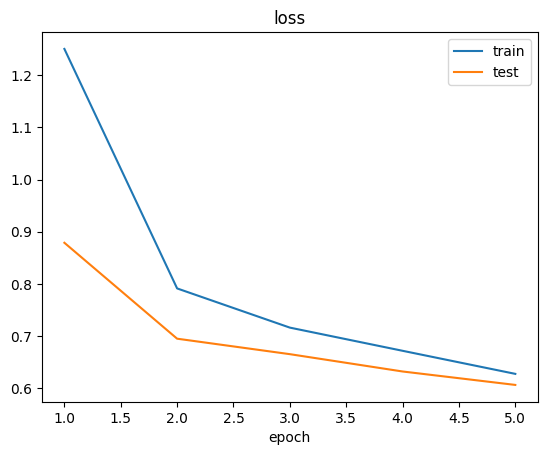

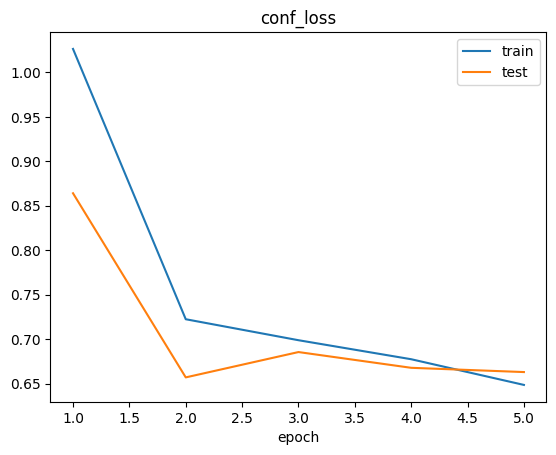

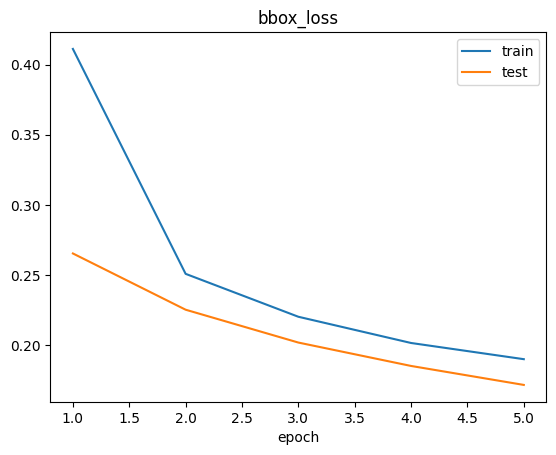

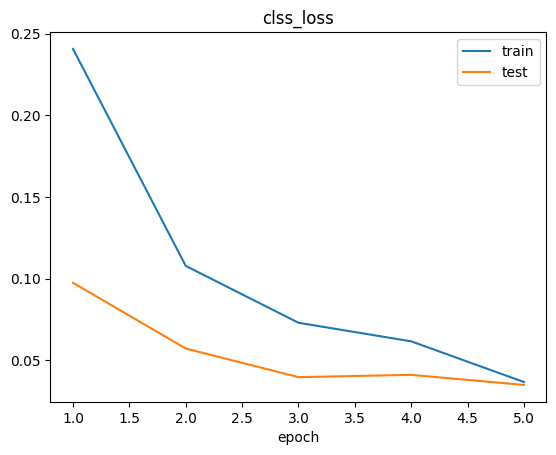

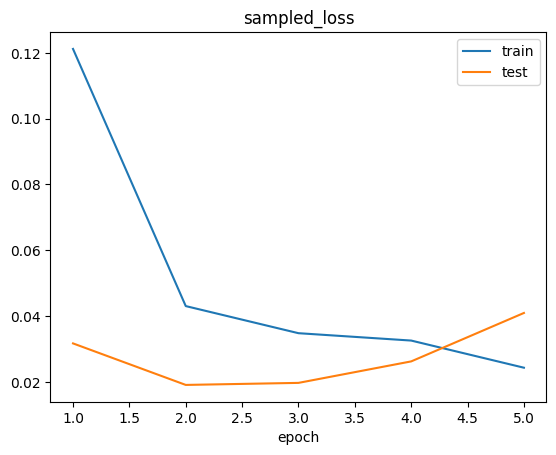

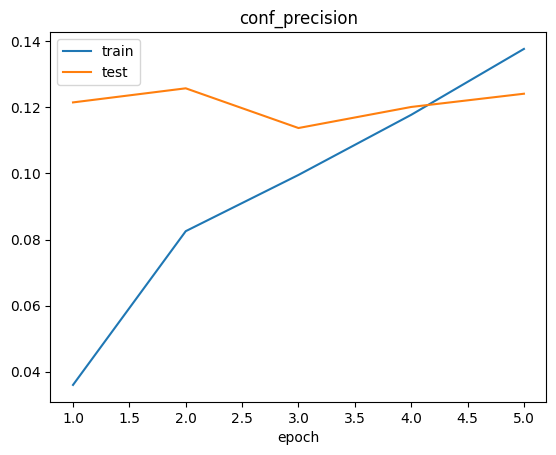

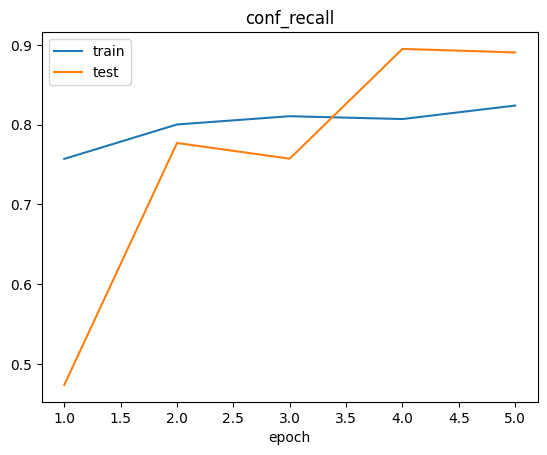

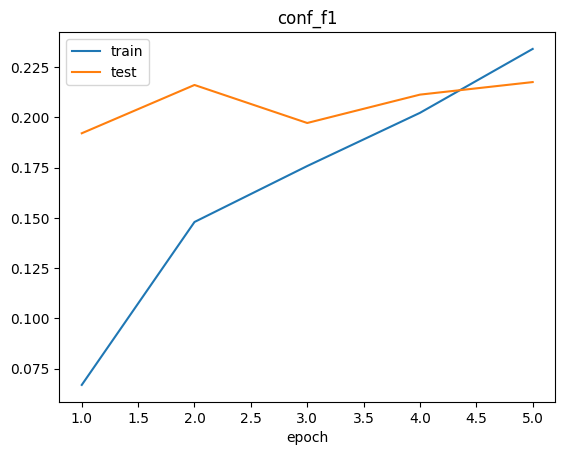

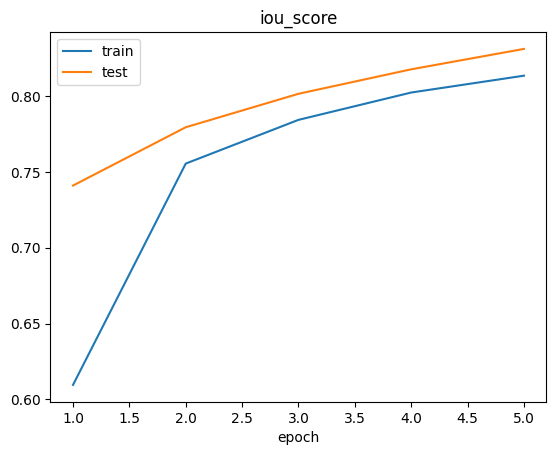

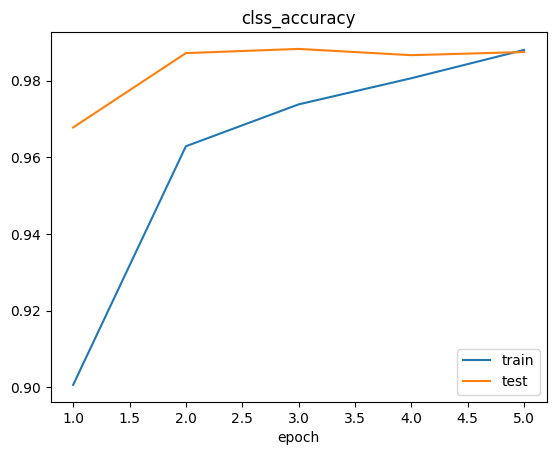

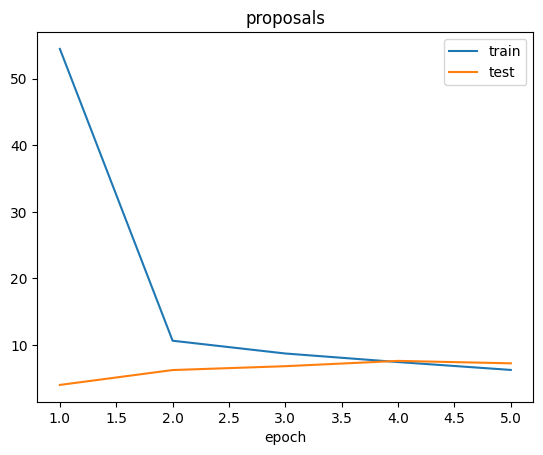

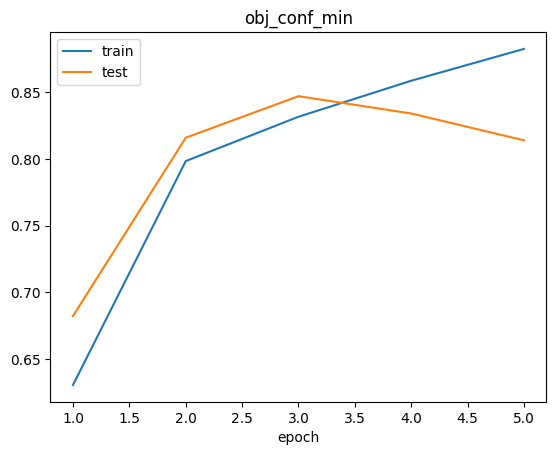

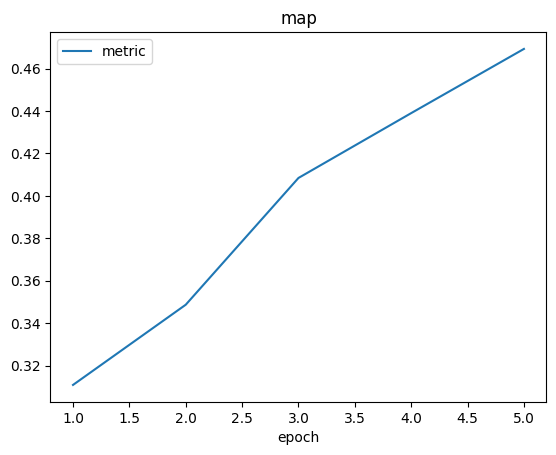

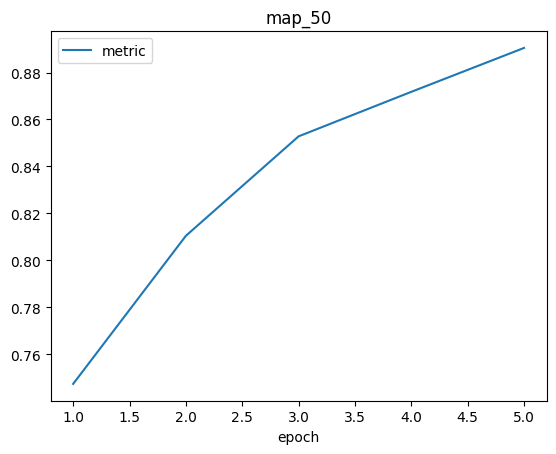

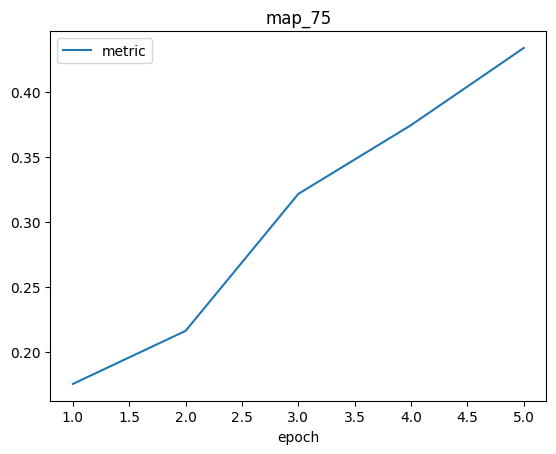

In [7]:
trainer.fit(max_train_step=0, max_test_step=0)